  # FEE PYX

Cython version of FEE class

In [2]:
from __future__ import print_function

In [3]:
import matplotlib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import Core.system_of_units as units
import Core.mplFunctions as mpl
import Core.wfmFunctions as wfm
import Core.tblFunctions as tbl
import Sierpe.FEE as FE
from scipy import signal
from Core.coreFunctions import wait
from Database import loadDB

In [5]:
import ICython.Core.system_of_units as SU

In [135]:
import Core.coreFunctions as crf

In [161]:
import Core.fit_library as fit

In [6]:
%load_ext Cython

In [7]:
import time

### Last revisited on:

In [72]:
print(time.strftime("%d/%m/%Y"))
print(time.strftime("%H:%M:%S"))

25/11/2016
10:13:44


In [70]:
DataPMT = loadDB.DataPMT()

In [71]:
DataPMT

,SensorID,ChannelID,PmtID,Active,X,Y,coeff_c,coeff_blr,adc_to_pes,noise_rms,sigma
0,0,0,1,1,-23.9414,65.7785,0.000003,0.001632,-24.3395,0.7060,7.73100
1,1,18,3,1,-44.9951,-53.6231,0.000003,0.001632,-24.8580,0.8744,8.82000
2,2,1,2,1,68.9365,-12.1554,0.000003,0.001611,-26.2934,0.7213,8.01375
3,3,19,4,1,0.0000,185.0000,0.000003,0.001599,-26.4110,0.7624,8.42224
4,4,27,C,1,-118.9160,141.7180,0.000003,0.001567,-26.7098,0.7921,6.23125
5,5,26,B,1,-182.1890,32.1249,0.000004,0.001650,-22.4456,0.8660,5.65180
6,6,9,A,1,-160.2150,-92.5000,0.000003,0.001593,-23.3552,0.7062,7.37840
7,7,8,9,1,-63.2737,-173.8430,0.000003,0.001612,-33.8821,0.7278,11.94840
8,8,23,8,1,63.2737,-173.8430,0.000003,0.001601,-21.8220,0.7303,6.11073
9,9,22,7,1,160.2150,-92.5000,0.000003,0.001593,-25.8020,0.7160,7.46200


In [73]:
coeff_c = DataPMT.coeff_c.values

In [74]:
coeff_c

array([  2.90544700e-06,   3.08000000e-06,   2.80060000e-06,
         2.75626500e-06,   3.13876600e-06,   3.96517600e-06,
         2.71100000e-06,   3.12764100e-06,   3.06454300e-06,
         3.04046300e-06,   3.11360400e-06,   3.18597900e-06])

In [75]:
coeff_blr = DataPMT.coeff_blr.values

In [76]:
coeff_blr

array([ 0.00163241,  0.00163241,  0.0016111 ,  0.00159936,  0.00156696,
        0.00164962,  0.00159296,  0.00161207,  0.00160068,  0.00159272,
        0.00157519,  0.00159632])

In [139]:
coeff_c_pmt = DataPMT.coeff_c.values

In [140]:
coeff_blr_pmt = DataPMT.coeff_blr.values

### Cython version

In [338]:
%%cython
"""
Classes and functions describing the electronics of the
PMT plane FEE.
(full model)
VH, JJGC, November, 2016
"""
import numpy as np
cimport numpy as np
from scipy import signal
import Database.loadDB as DB
cimport ICython.Core.system_of_units as SU


cdef class FEEGlobals:
    cdef readonly double PMT_GAIN, x_slope, x_flat, FEE_GAIN, DAQ_GAIN, LSB, NOISE_I
    cdef readonly NOISE_DAQ, C2, C1, R1, Zin, t_sample, time_step, f_sample, f_mc 
    cdef readonly f_LPF1, f_LPF2, ADC_TO_PES_LPF, ADC_TO_PES 
    cdef readonly int NBITS, OFFSET, CEILING 
    
    def __init__(self):
        units = SU.SystemOfUnits()

        self.PMT_GAIN = 1.7e6
        self.x_slope=5.*units.ns
        self.x_flat=1.*units.ns
        self.FEE_GAIN = 582.237*units.ohm
        self.DAQ_GAIN = 1.25
        self.NBITS = 12
        self.LSB = 2.0*units.V/2**self.NBITS/self.DAQ_GAIN
        self.NOISE_I = self.LSB/(self.FEE_GAIN*self.DAQ_GAIN)
        self.NOISE_DAQ = 0.313*units.mV

        self.C2 = 8*units.nF
        self.C1 = 2714*units.nF
        self.R1 = 1567*units.ohm
        self.Zin = 62*units.ohm
        self.t_sample = 25*units.ns
        self.f_sample = 1./self.t_sample
        self.time_step = 1.*units.ns
        self.f_mc = 1./self.time_step
        self.f_LPF1 = 3*units.MHZ
        self.f_LPF2 = 10*units.MHZ
        self.ADC_TO_PES_LPF = 24.1  # After LPF, comes out from spe area
        self.ADC_TO_PES = 23.1
        self.OFFSET = 2500  # offset adc
        self.CEILING = 4096  # ceiling of adc

    cpdef double i_to_adc(self):
        """
        current to adc counts
        """
        return self.FEE_GAIN/self.LSB


    cpdef double i_to_v(self):
        """
        current to voltage
        """
        return self.FEE_GAIN


    cpdef double v_to_adc(self):
        """
        voltage to adc
        """
        return 1./self.LSB

    
cdef class SPE:
    """
    Represents a single photo-electron in the PMT
    """
    
    cdef FEEGlobals fee
    cdef SU.SystemOfUnits units
    cdef double A
    
    def __init__(self):
        self.fee = FEEGlobals()
        self.units = SU.SystemOfUnits()
                
    
    cpdef np.ndarray[np.float64_t, ndim=1] spe(self):
        """
        single photoelectron pulse
        """
        
        cdef double spe_base = self.fee.x_slope + self.fee.x_flat
        self.A = self.fee.PMT_GAIN*self.units.eplus/spe_base
        cdef int nns = int(self.fee.x_slope/self.fee.time_step)
        cdef int nnf = int(self.fee.x_flat/self.fee.time_step)
 
        cdef np.ndarray[np.float64_t, ndim=1] rise = np.linspace(0, self.A, num=nns)
        cdef np.ndarray[np.float64_t, ndim=1] fall = np.linspace(self.A, 0, num=nns)
        cdef np.ndarray[np.float64_t, ndim=1] flat = self.A*np.ones(nnf)
        
        return np.concatenate((rise, flat, fall))
    
    cpdef np.ndarray[np.float64_t, ndim=1] spe_pulse(self, float t0, float tmax, float time_step):
        """
    
        Returns a SPE pulse at time t0
        with baseline extending in steps of time_step from 0 to tmax
        determined by DELTA_L
        """
        cdef int n = int(t0/time_step)
        cdef int nmax = int(tmax/time_step)

        cdef  np.ndarray[np.float64_t, ndim=1] DELTA = np.zeros(nmax)   # Dirac delta of size DELTA_L
        DELTA[n] = 1
    
        cdef  np.ndarray[np.float64_t, ndim=1] spe_pulse = signal.convolve(DELTA, self.spe())

        return spe_pulse
    
    cpdef np.ndarray[np.float64_t, ndim=1] spe_pulse_train(self,
                                                           signal_start,
                                                           signal_length, 
                                                           daq_window,
                                                           time_step):
        """
        Returns a train of SPE pulses between signal_start
        and start+length in daq_window separated by tstep
        """
        cdef int nmin = int(signal_start/time_step)
        cdef int nmax = int((signal_start + signal_length)/time_step)
        cdef int NMAX = int(daq_window/time_step)
    
        cdef  np.ndarray[np.float64_t, ndim=1] DELTA = np.zeros(NMAX)
        DELTA[nmin:nmax+1] = 1.
    
        cdef np.ndarray[np.float64_t, ndim=1] spe_pulse = signal.convolve(DELTA, self.spe())

        return spe_pulse
    
    cpdef np.ndarray[np.float64_t, ndim=1] spe_pulse_from_ivector(self, np.ndarray[np.int64_t, ndim=1] cnt):
        """
        Returns a train of SPE pulses corresponding to vector cnt
        """

        return signal.convolve(cnt[0:-len(self.spe())+1], self.spe())
    
    cpdef np.ndarray[np.float64_t, ndim=1] spe_pulse_from_pes(self, np.ndarray[np.int16_t, ndim=1] cnt):
        """
        Returns a train of SPE pulses corresponding to vector cnt
        """

        return signal.convolve(cnt[0:-len(self.spe())+1], self.spe())


    
    cpdef np.ndarray[np.float64_t, ndim=1] spe_pulse_from_fvector(self, np.ndarray[np.float64_t, ndim=1] cnt):
        """
        Returns a train of SPE pulses corresponding to vector cnt
        """

        return signal.convolve(cnt[0:-len(self.spe())+1], self.spe())


cdef class FEE:
    """
    Complete model of Front-end electronics.
    """
    cdef double noise_FEEPMB_rms, noise_DAQ_rms
    cdef double A1, A2, C, R, Cr, ZC
    cdef double freq_LHPF, freq_LPF1, freq_LPF2 
    cdef double freq_LHPFd, freq_LPF1d, freq_LPF2d, freq_zero 
    cdef readonly double coeff_blr, coeff_c

    cdef FEEGlobals fee
    cdef readonly double coeff_blr_pmt[12] 
    cdef readonly double coeff_c_pmt[12] 
    cdef double freq_LHPFd_pmt[12]
    cdef double C1_pmt[12] 
    cdef double R1_pmt[12]
    cdef double A1_pmt[12] 
    cdef double A2_pmt[12]
    cdef double Cr_pmt[12]
    cdef double ZC_pmt[12]
    
    
    def __init__(self, coeff_blr_pmt, coeff_c_pmt, noise_FEEPMB_rms, noise_DAQ_rms):
        self.fee = FEEGlobals()
        self.coeff_blr_pmt = coeff_blr_pmt
        self.coeff_c_pmt = coeff_c_pmt
        self.noise_FEEPMB_rms = noise_FEEPMB_rms
        self.noise_DAQ_rms = noise_DAQ_rms
        
        self.A1 = self.fee.R1 * self.fee.Zin/(self.fee.R1 + self.fee.Zin)  # ohms
        self.A2 = self.fee.FEE_GAIN/self.A1  # ohms/ohms = []
        self.R =  self.fee.R1 + self.fee.Zin
        self.Cr = 1. + self.fee.C1/self.fee.C2
        self.C =  self.fee.C1/self.Cr
        self.ZC = self.fee.Zin/self.Cr

        self.freq_LHPF = 1./(self.R * self.C)
        self.freq_LPF1 = self.fee.f_LPF1 * 2 * np.pi
        self.freq_LPF2 = self.fee.f_LPF2 * 2 * np.pi

        self.freq_LHPFd = self.freq_LHPF/(self.fee.f_sample * np.pi)
        self.freq_LPF1d = self.freq_LPF1/(self.fee.f_sample * np.pi)
        self.freq_LPF2d = self.freq_LPF2/(self.fee.f_sample  *np.pi)
        
        self.coeff_blr = self.freq_LHPFd * np.pi
        self.freq_zero = 1./(self.fee.R1 * self.fee.C1)
        self.coeff_c = self.freq_zero/(self.fee.f_sample * np.pi)
        
        cdef int i
        for i in range(12):
            self.freq_LHPFd_pmt[i] = self.coeff_blr_pmt[i]/np.pi
            self.C1_pmt[i] = (self.coeff_blr_pmt[i]/self.coeff_c_pmt[i])*(self.fee.C2/np.pi)
            self.R1_pmt[i] = 1./(self.coeff_c_pmt[i]*self.C1_pmt[i]*self.fee.f_sample*np.pi)
            self.A1_pmt[i] = self.R1_pmt[i] * self.fee.Zin/(self.R1_pmt[i] + self.fee.Zin)  # ohms
            self.A2_pmt[i] = self.fee.FEE_GAIN/self.A1_pmt[i]  # ohms/ohms = []
            self.Cr_pmt[i] = 1. + self.C1_pmt[i]/self.fee.C2
            self.ZC_pmt[i] = self.fee.Zin/self.Cr_pmt[i]
        
    
    cpdef np.ndarray[np.float64_t, ndim=1] noise_adc(self, 
                                                     np.ndarray[np.float64_t, ndim=1] signal_in_adc):
        """
        Equivalent Noise of the DAQ added at the output
        of the system
        input: a signal (in units of adc counts)
        output: a signal with DAQ noise added
        """
        
        cdef double noise_daq = self.fee.NOISE_DAQ * self.fee.v_to_adc()
        return signal_in_adc + np.random.normal(0,
                                                noise_daq,
                                                len(signal_in_adc))
    
    cpdef filter_sfee_lpf(self):
        """
        output: buttersworth parameters of the equivalent LPF 
        """
        # LPF order 1
        cdef np.ndarray[np.float64_t, ndim=1] a1, b1, a2, b2, b_aux, b
        
        b1, a1 = signal.butter(1, self.freq_LPF1d, 'low', analog=False)
        # LPF order 4
        b2, a2 = signal.butter(4, self.freq_LPF2d, 'low', analog=False)
        # convolve LPF1, LPF2
        a = np.convolve(a1, a2, mode='full')
        b_aux = np.convolve(b1, b2, mode='full')
        b = self.fee.FEE_GAIN*b_aux
        return b, a
    
    cpdef filter_fee(self, int ipmt):
        """
           ipmt = pmt number
           output: buttersworth parameters of the equivalent FEE filter
        """

    
        cdef double coef = self.freq_LHPFd_pmt[ipmt]
        cdef double A1 = self.A1_pmt[ipmt]
        cdef double A2 = self.A2_pmt[ipmt]
        cdef double ZC = self.ZC_pmt[ipmt]
    
        if ipmt == -1:
            coef = self.freq_LHPFd
            A1 = self.A1
            A2 = self.A2
            ZC = self.ZC
    
        cdef np.ndarray[np.float64_t, ndim=1] a1, b1, a2, b2, a0, b0, b11, a11, b21, a21 
        cdef np.ndarray[np.float64_t, ndim=1] a_aux, b_aux, b_aux2, a, b
    
        b1, a1 = signal.butter(1, coef, 'high', analog=False)
        b2, a2 = signal.butter(1, coef, 'low', analog=False)

        b0 = b2*ZC + b1*A1  # in ohms
        a0 = a1

        # LPF order 1
        b1l, a1l = signal.butter(1,
                                 self.freq_LPF1d, 'low',
                                 analog=False)
        # LPF order 4
        b2l, a2l = signal.butter(4,
                                 self.freq_LPF2d, 'low',
                                 analog=False)
        # convolve HPF, LPF1
        a_aux = np.convolve(a0, a1l, mode='full')
        b_aux = np.convolve(b0, b1l, mode='full')
    
        # convolve HPF+LPF1, LPF2
        a = np.convolve(a_aux, a2l, mode='full')
        b_aux2 = np.convolve(b_aux, b2l, mode='full')
        b = A2*b_aux2  # in ohms

        return b, a
   
    cpdef filter_cleaner(self, int ipmt):
        """
        cleans the input signal
        """
        cdef double coef = self.coeff_c_pmt[ipmt]
        if ipmt == -1:
            coef = self.coeff_c
        
        cdef np.ndarray[np.float64_t, ndim=1] a, b
    
        b, a = signal.butter(1, coef, 'high', analog=False)

        return b, a
    
    cpdef np.ndarray[np.float64_t, ndim=1] signal_v_lpf(self, np.ndarray[np.float64_t, ndim=1] signal_in):
        """
        input: instance of class sfe and a current signal
        outputs: signal convolved with LPF in voltage
        """
        cdef np.ndarray[np.float64_t, ndim=1] a, b
        
        b, a = self.filter_sfee_lpf()
        return signal.lfilter(b, a, signal_in)

    
    cpdef np.ndarray[np.float64_t, ndim=1] signal_v_fee(self, 
                                                        np.ndarray[np.float64_t, ndim=1] signal_i, 
                                                        int ipmt):
        """
        input: signal_i = signal current (i = A)
           pmt number
        output: signal_v (in volts) with effect FEE

        ++++++++++++++++++++++++++++++++++++++++++++++++
        +++++++++++ PMT+FEE NOISE ADDED HERE +++++++++++
        ++++++++++++++++++++++++++++++++++++++++++++++++

        """
        
        cdef np.ndarray[np.float64_t, ndim=1] noise_FEEin = np.zeros(len(signal_i))
        if self.noise_FEEPMB_rms > 0:
            noise_FEEin = np.random.normal(0,
                                           self.noise_FEEPMB_rms,
                                           len(signal_i))

        # Equivalent Noise of the FEE + PMT BASE added at the input
        # of the system to get the noise filtering effect
        cdef np.ndarray[np.float64_t, ndim=1] a, b

        b, a = self.filter_fee(ipmt)  # b in ohms
        # filtered signal in I*R = V
        return signal.lfilter(b, a, signal_i + noise_FEEin)
    
    
    cpdef np.ndarray[np.float64_t, ndim=1] signal_clean(self, 
                                                        np.ndarray[np.float64_t, ndim=1] signal_fee, 
                                                        int ipmt):
        """
        input: signal_fee = adc, convoluted
           instance of class FEE
        output: signal_c cleaning filter passed

        """
        cdef np.ndarray[np.float64_t, ndim=1] a, b
        b, a = self.filter_cleaner(ipmt)
        return signal.lfilter(b, a, signal_fee)
    
    cpdef np.ndarray[np.float64_t, ndim=1] daq_decimator(self,
                                                         float f_sample1, 
                                                         float f_sample2, 
                                                         np.ndarray[np.float64_t, ndim=1] signal_in):
        """
        downscales the signal vector according to the
        scale defined by f_sample1 (1 GHZ) and
        f_sample2 (40 Mhz).
        Includes anti-aliasing filter
        """

        cdef int scale = int(f_sample1/f_sample2)
        return signal.decimate(signal_in, scale, ftype='fir')



### Globals and units, cyton style

In [205]:
feg = FEEGlobals()
units = SU.SystemOfUnits()

### SPE, cython and python

In [206]:
cspe = SPE()

In [207]:
spe = FE.SPE()

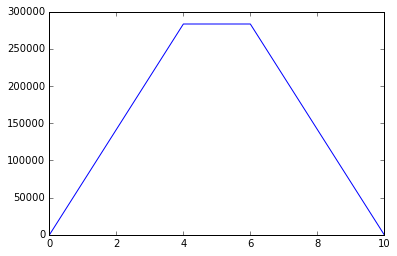

In [208]:
plt.plot(spe.spe)

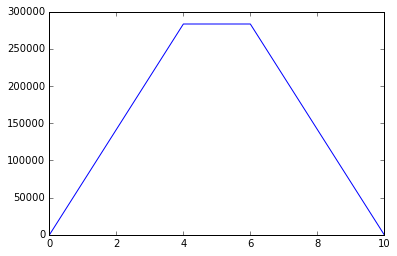

In [209]:
plt.plot(cspe.spe())

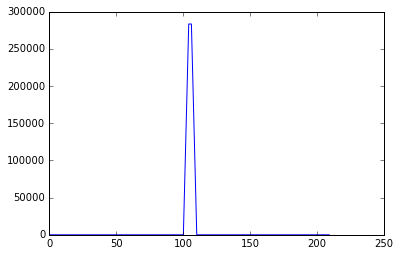

In [210]:
plt.plot(FE.spe_pulse(spe,t0=100*units.ns, tmax=200*units.ns,
              time_step=1*units.ns))

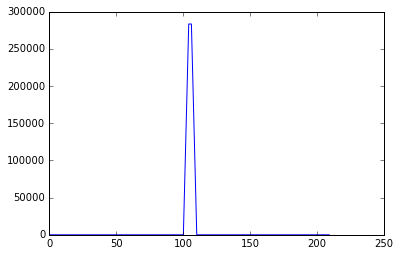

In [211]:
plt.plot(cspe.spe_pulse(t0=100*units.ns, tmax=200*units.ns,
              time_step=1*units.ns))

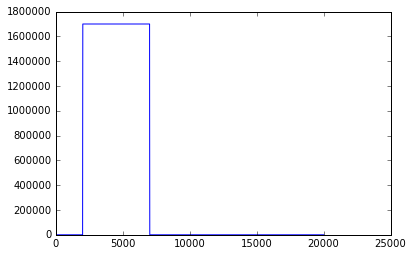

In [212]:
plt.plot(FE.spe_pulse_train(spe,
                    signal_start=2000*units.ns,
                    signal_length=5000*units.ns, daq_window=20*units.mus,
                    time_step=1*units.ns))

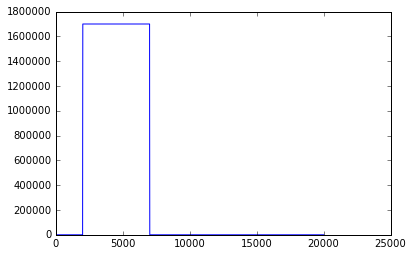

In [213]:
plt.plot(cspe.spe_pulse_train(signal_start=2000*units.ns,
                    signal_length=5000*units.ns, daq_window=20*units.mus,
                    time_step=1*units.ns))

In [214]:
cnt = np.random.poisson(5, 10000)

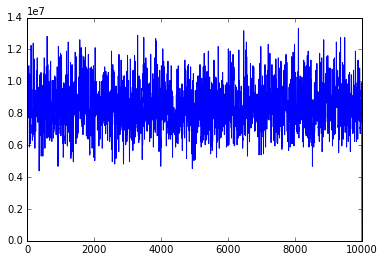

In [215]:
plt.plot(FE.spe_pulse_from_vector(spe, cnt))

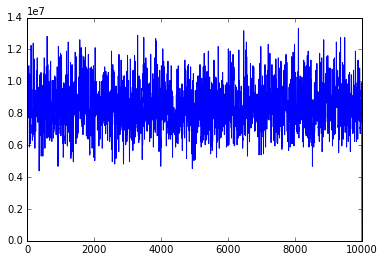

In [216]:
plt.plot(cspe.spe_pulse_from_ivector(cnt))

### FEE instance, python and cython

In [273]:
pfee = FE.FEE(noise_FEEPMB_rms=1*FE.NOISE_I,noise_DAQ_rms=FE.NOISE_DAQ)
cfee = FEE(coeff_blr_pmt, coeff_c_pmt, feg.NOISE_I, feg.NOISE_DAQ) 

In [218]:
ipmt=-1
b,a = FE.filter_fee(pfee, ipmt)

In [219]:
print('filter parameters: a = {} b = {} ohm'.format(a, b/units.ohm))

filter parameters: a = [ 1.         -1.61087863  1.09765171 -0.78293344  0.31493115 -0.02845585
  0.0108042 ] b = [  1.05834516e+01   4.23338687e+01   5.29175691e+01   6.22138897e-04
  -5.29166359e+01  -4.23334954e+01  -1.05833894e+01] ohm


In [220]:
cfee.coeff_blr

0.0019240095125518364

In [221]:
cfee.coeff_c

1.8711615995236043e-06

In [222]:
b,a = cfee.filter_fee(ipmt)

In [223]:
print('Cython: filter parameters: a = {} b = {} ohm'.format(a, b/units.ohm))

Cython: filter parameters: a = [ 1.         -1.61087863  1.09765171 -0.78293344  0.31493115 -0.02845585
  0.0108042 ] b = [  1.05834516e+01   4.23338687e+01   5.29175691e+01   6.22138897e-04
  -5.29166359e+01  -4.23334954e+01  -1.05833894e+01] ohm


In [224]:
def filter_fee_ut(fee,cfee):
    for i in range(12):
        b1,a1 = FE.filter_fee(fee, ipmt)
        b2,a2 = cfee.filter_fee(ipmt)
        assert(np.abs(b1-b2).all() < 1e-6)
        assert(np.abs(a1-a2).all() < 1e-6)
    print('test passed')
    

In [225]:
filter_fee_ut(fee,cfee)

test passed


In [226]:
def signal_i_th():
    """
    generates a "theoretical" current signal (signal_i)
    """
    return np.concatenate((np.zeros(1000),np.linspace(0,0.5,2000),np.linspace(0.5,0,1000),
                            np.linspace(0,1,1000),np.linspace(1,0,2000),
                            np.linspace(0,1,2000),np.linspace(1,0,2000),
                            np.zeros(20000)),axis=0)*units.mA

In [227]:
signal_i = signal_i_th()

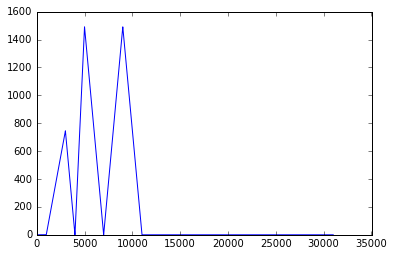

In [228]:
plt.plot(range(0,np.size(signal_i),1),signal_i*FE.i_to_adc())   #plot input signal in adc counts

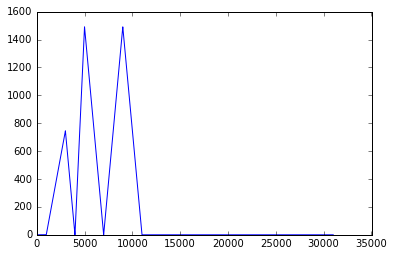

In [229]:
plt.plot(range(0,np.size(signal_i),1),signal_i*feg.i_to_adc())   #plot input signal in adc counts

In [230]:
psignal_out = FE.signal_v_fee(pfee, signal_i, -1)

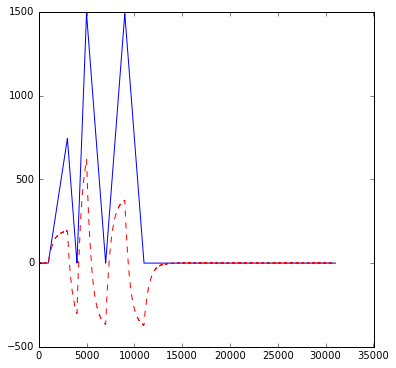

In [231]:
plt.figure(figsize=(6, 6))
plt.plot(range(0,np.size(signal_i),1),signal_i*FE.i_to_adc())
plt.plot(range(0,np.size(signal_i),1),psignal_out*FE.v_to_adc(),'r--', linewidth=1)
plt.show()

In [232]:
csignal_out = cfee.signal_v_fee(signal_i, -1)

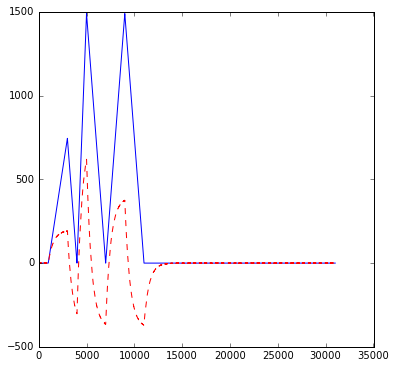

In [234]:
plt.figure(figsize=(6, 6))
plt.plot(range(0,np.size(signal_i),1),signal_i*FE.i_to_adc())
plt.plot(range(0,np.size(signal_i),1),csignal_out*FE.v_to_adc(),'r--', linewidth=1)
plt.show()

In [248]:
psignal_outnd = FE.noise_adc(pfee,psignal_out*FE.v_to_adc())

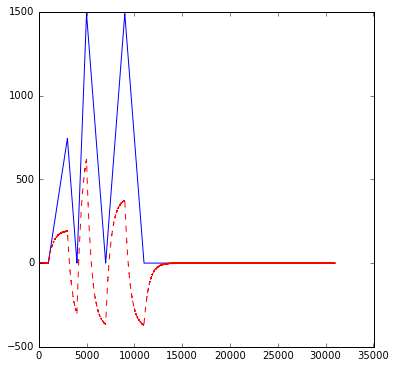

In [251]:
plt.figure(figsize=(6, 6))
plt.plot(range(0,np.size(signal_i),1),signal_i*FE.i_to_adc())
plt.plot(range(0,np.size(signal_i),1),psignal_outnd,'r--', linewidth=1)
plt.show()

In [249]:
csignal_outnd = cfee.noise_adc(csignal_out*feg.v_to_adc())

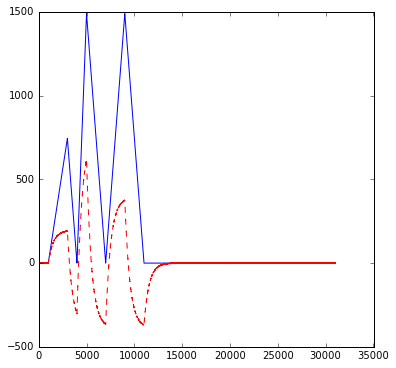

In [252]:
plt.figure(figsize=(6, 6))
plt.plot(range(0,np.size(signal_i),1),signal_i*FE.i_to_adc())
plt.plot(range(0,np.size(signal_i),1),csignal_outnd,'r--', linewidth=1)
plt.show()

In [254]:
print("Python: Out Noise FEE (LSB_rms) ={}".format(
        np.std(psignal_outnd[25000:26000],ddof=1)))

Python: Out Noise FEE (LSB_rms) =0.86487028133


In [255]:
print("Cython: Out Noise FEE (LSB_rms) ={}".format(
        np.std(csignal_outnd[25000:26000],ddof=1)))

Cython: Out Noise FEE (LSB_rms) =0.878903003998


### Clean signal

In [256]:
psignal_out_cf = FE.signal_clean(fee, psignal_outnd, -1)

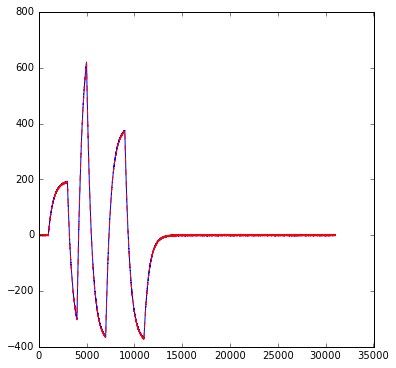

In [257]:
plt.figure(figsize=(6, 6))
plt.plot(range(0,np.size(signal_i),1),psignal_outnd, linewidth=1)
plt.plot(range(0,np.size(signal_i),1),psignal_out_cf,'r--', linewidth=1)
plt.show()

In [258]:
csignal_out_cf = cfee.signal_clean(csignal_outnd, -1)

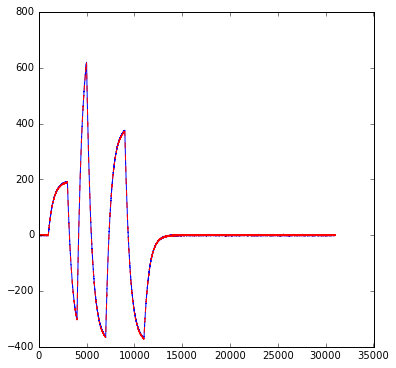

In [259]:
plt.figure(figsize=(6, 6))
plt.plot(range(0,np.size(signal_i),1),csignal_outnd, linewidth=1)
plt.plot(range(0,np.size(signal_i),1),csignal_out_cf,'r--', linewidth=1)
plt.show()

### Deconvolution (python and cython versions)

In [144]:
def deconv_simple(signal,coef):
    """
    Deconvolution of the fine-grained fee signal (no DAQ)
    no noise
    using true start and end of signals
    """

    acum = np.zeros(len(signal))

    acum[0]=coef*signal[0]
    for n in np.arange(1,len(signal)):
        acum[n] = acum[n-1] + signal[n]

    signal_r = signal + coef*acum

    return signal_r, acum

In [154]:
%%cython
cimport numpy as np
import numpy as np
def cdeconv_simple(double [:] signal, double coef):
    """
    Deconvolution of the fine-grained fee signal (no DAQ)
    no noise
    using true start and end of signals
    """

    cdef double [:] acum = np.zeros(len(signal), dtype=np.double)
    cdef double [:] signal_r = np.zeros(len(signal), dtype=np.double)


    signal_r[0] = signal[0]
    cdef int k
    for k in range(1,len(signal)):
        signal_r[k] = signal[k] + signal[k]*(coef/2.0) + coef * acum[k-1]
        acum[k] = acum[k-1] + signal[k]

    return signal_r, acum

### Plot Python functions (with cython deconv)

In [298]:
def pwfm(pfee, signal_i):
    """
    plots waveforms all PMTs
    """
    
    coef=pfee.freq_LHPFd*np.pi
    coef_c = pfee.coeff_c
    PMT = [-1,0,1,2,3,4,5,6,7,8,9,10,11]

    for i in PMT:
        if i>-1: 
            coef = pfee.coeff_blr_pmt[i]
            coef_c = pfee.coeff_c_pmt[i]
        print('pmt = {}, coeff_blr = {}, coeff_c = {}'.format(i,coef,coef_c))
        signal_outn = FE.signal_v_fee(pfee, signal_i, i)   # convolution and noise FEE + PMT 
        signal_outnd = FE.noise_adc(pfee, signal_outn*FE.v_to_adc())  # NOISE DAQ
        signal_out_cf = FE.signal_clean(pfee, signal_outnd, i)  # cleaning.
        signal_r, acum = cdeconv_simple(signal_out_cf,coef=coef)
        print('sum: signal_i = {} '.format(np.sum(signal_i[1000:11000])*FE.i_to_adc()))
        print('sum: signal_r ={}'.format(np.sum(signal_r[1000:11000])))
        print('signal_i/signal_r ={}'.format(np.sum(signal_i[1000:11000])*FE.i_to_adc()/np.sum(signal_r[1000:11000])))
        plt.figure(figsize=(6, 6))
        plt.plot(range(0,np.size(signal_i),1),signal_i*FE.i_to_adc())
        plt.plot(range(0,np.size(signal_i),1),signal_out_cf,'r--', linewidth=1)
        plt.plot(range(0,np.size(signal_i),1),signal_r,'k--', linewidth=1)
        plt.show()
    #crf.wait()

pmt = -1, coeff_blr = 0.00192400951255, coeff_c = 1.87116159952e-06
sum: signal_i = 6334738.56 
sum: signal_r =6335570.56752
signal_i/signal_r =0.999868676781


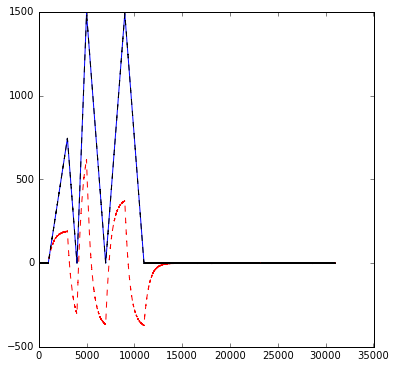

pmt = 0, coeff_blr = 0.001632411, coeff_c = 2.905447e-06
sum: signal_i = 6334738.56 
sum: signal_r =6340655.8901
signal_i/signal_r =0.999066763723


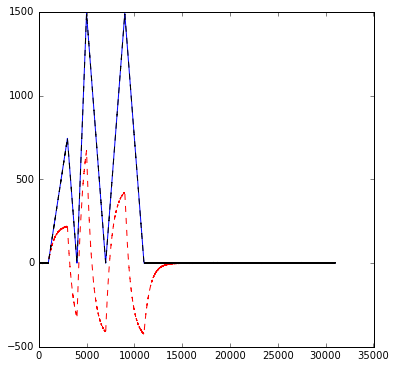

pmt = 1, coeff_blr = 0.001632411, coeff_c = 3.08e-06
sum: signal_i = 6334738.56 
sum: signal_r =6342667.84757
signal_i/signal_r =0.998749849785


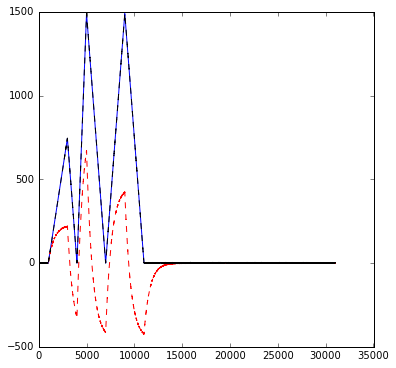

pmt = 2, coeff_blr = 0.001611104, coeff_c = 2.8006e-06
sum: signal_i = 6334738.56 
sum: signal_r =6341194.28268
signal_i/signal_r =0.998981938986


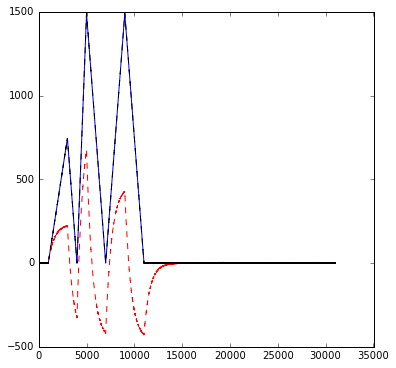

pmt = 3, coeff_blr = 0.001599356, coeff_c = 2.756265e-06
sum: signal_i = 6334738.56 
sum: signal_r =6340023.65112
signal_i/signal_r =0.999166392523


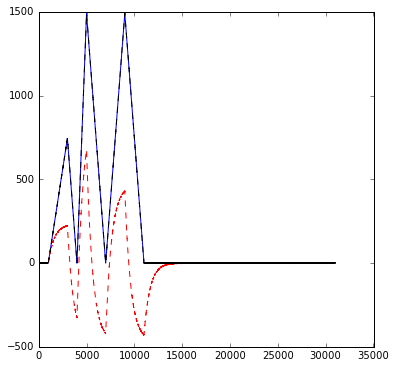

pmt = 4, coeff_blr = 0.001566958, coeff_c = 3.138766e-06
sum: signal_i = 6334738.56 
sum: signal_r =6341569.51165
signal_i/signal_r =0.998922829493


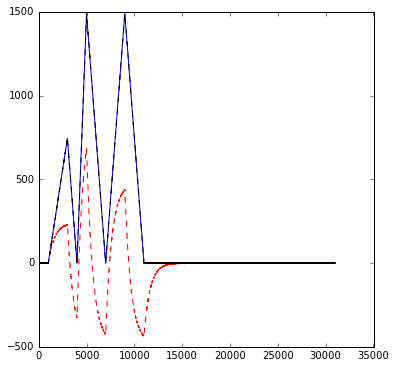

pmt = 5, coeff_blr = 0.001649618, coeff_c = 3.965176e-06
sum: signal_i = 6334738.56 
sum: signal_r =6344324.006
signal_i/signal_r =0.998489130443


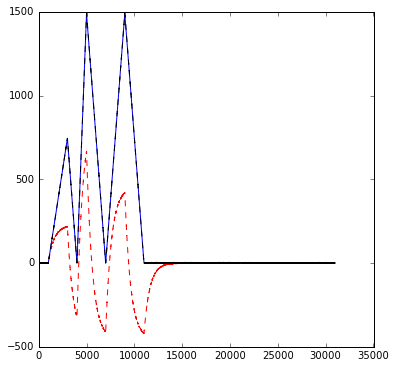

pmt = 6, coeff_blr = 0.001592963, coeff_c = 2.711e-06
sum: signal_i = 6334738.56 
sum: signal_r =6340621.0847
signal_i/signal_r =0.999072247872


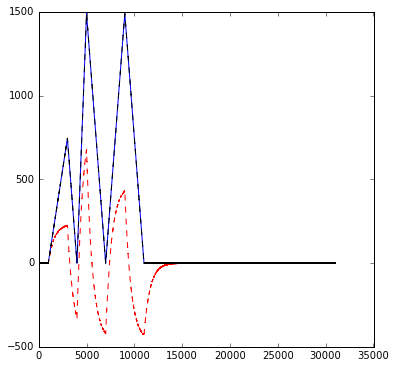

pmt = 7, coeff_blr = 0.001612068, coeff_c = 3.127641e-06
sum: signal_i = 6334738.56 
sum: signal_r =6340674.91217
signal_i/signal_r =0.999063766516


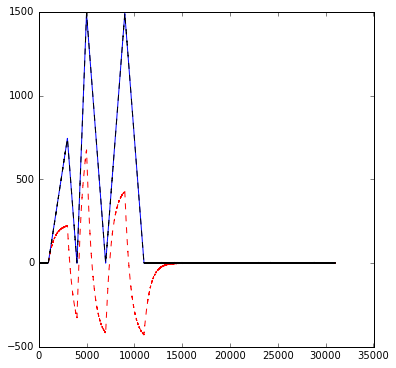

pmt = 8, coeff_blr = 0.001600683, coeff_c = 3.064543e-06
sum: signal_i = 6334738.56 
sum: signal_r =6340403.85959
signal_i/signal_r =0.999106476541


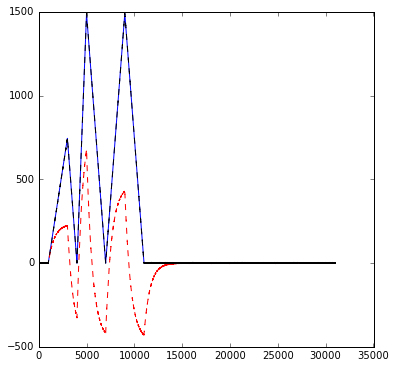

pmt = 9, coeff_blr = 0.001592718, coeff_c = 3.040463e-06
sum: signal_i = 6334738.56 
sum: signal_r =6341719.05433
signal_i/signal_r =0.998899274113


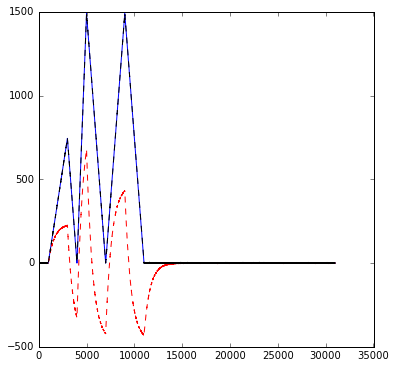

pmt = 10, coeff_blr = 0.001575192, coeff_c = 3.113604e-06
sum: signal_i = 6334738.56 
sum: signal_r =6340536.46704
signal_i/signal_r =0.999085580996


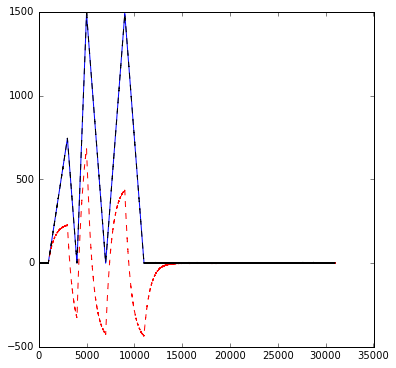

pmt = 11, coeff_blr = 0.001596322, coeff_c = 3.185979e-06
sum: signal_i = 6334738.56 
sum: signal_r =6339324.61634
signal_i/signal_r =0.999276570201


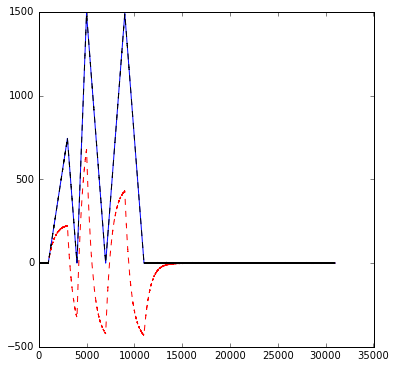

In [299]:
pwfm(pfee, signal_i)

### Plot cython functions (with cython deconv)

In [300]:
def cwfm(cfee, signal_i):
    """
    plots waveforms all PMTs
    """
    
    coef=cfee.coeff_blr
    coef_c = cfee.coeff_c
    PMT = [-1,0,1,2,3,4,5,6,7,8,9,10,11]

    for i in PMT:
        if i>-1: 
            coef = cfee.coeff_blr_pmt[i]
            coef_c = cfee.coeff_c_pmt[i]
        print('pmt = {}, coeff_blr = {}, coeff_c = {}'.format(i,coef,coef_c))
        csignal_out = cfee.signal_v_fee(signal_i, i) # convolution and noise FEE + PMT
        csignal_outnd = cfee.noise_adc(csignal_out*feg.v_to_adc()) # NOISE DAQ
        csignal_out_cf = cfee.signal_clean(csignal_outnd, i) # cleaning.
        signal_r, acum = cdeconv_simple(csignal_out_cf,coef=coef)
        print('sum: signal_i = {} '.format(np.sum(signal_i[1000:11000])*FE.i_to_adc()))
        print('sum: signal_r ={}'.format(np.sum(signal_r[1000:11000])))
        print('signal_i/signal_r ={}'.format(np.sum(signal_i[1000:11000])*FE.i_to_adc()/np.sum(signal_r[1000:11000])))
        plt.figure(figsize=(6, 6))
        plt.plot(range(0,np.size(signal_i),1),signal_i*FE.i_to_adc())
        plt.plot(range(0,np.size(signal_i),1),csignal_out_cf,'r--', linewidth=1)
        plt.plot(range(0,np.size(signal_i),1),signal_r,'k--', linewidth=1)
        
        plt.show()

pmt = -1, coeff_blr = 0.00192400951255, coeff_c = 1.87116159952e-06
sum: signal_i = 6334738.56 
sum: signal_r =6336748.87498
signal_i/signal_r =0.999682752936


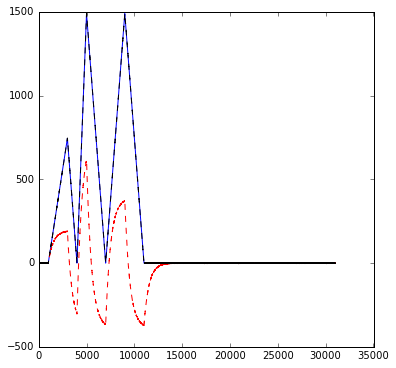

pmt = 0, coeff_blr = 0.001632411, coeff_c = 2.905447e-06
sum: signal_i = 6334738.56 
sum: signal_r =6340929.27612
signal_i/signal_r =0.999023689455


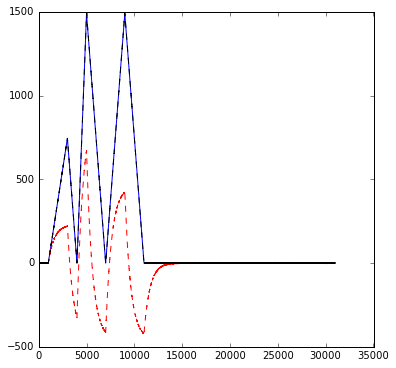

pmt = 1, coeff_blr = 0.001632411, coeff_c = 3.08e-06
sum: signal_i = 6334738.56 
sum: signal_r =6342231.11681
signal_i/signal_r =0.998818624444


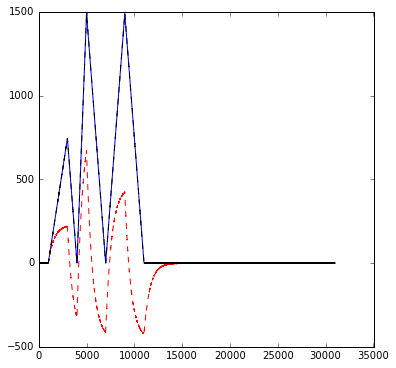

pmt = 2, coeff_blr = 0.001611104, coeff_c = 2.8006e-06
sum: signal_i = 6334738.56 
sum: signal_r =6339857.80742
signal_i/signal_r =0.999192529616


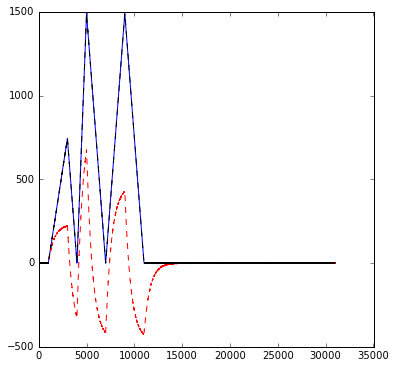

pmt = 3, coeff_blr = 0.001599356, coeff_c = 2.756265e-06
sum: signal_i = 6334738.56 
sum: signal_r =6342394.75283
signal_i/signal_r =0.998792854572


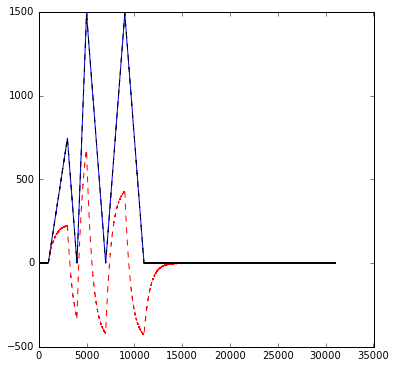

pmt = 4, coeff_blr = 0.001566958, coeff_c = 3.138766e-06
sum: signal_i = 6334738.56 
sum: signal_r =6342010.61753
signal_i/signal_r =0.99885335141


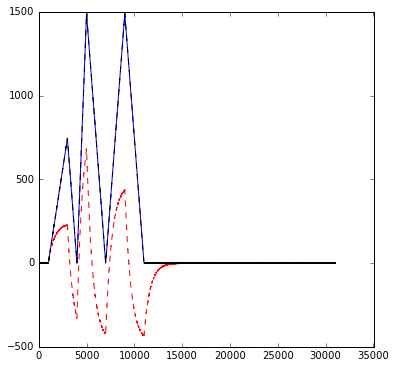

pmt = 5, coeff_blr = 0.001649618, coeff_c = 3.965176e-06
sum: signal_i = 6334738.56 
sum: signal_r =6342127.9696
signal_i/signal_r =0.998834869047


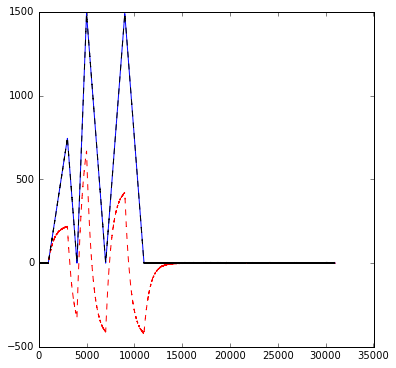

pmt = 6, coeff_blr = 0.001592963, coeff_c = 2.711e-06
sum: signal_i = 6334738.56 
sum: signal_r =6340357.79472
signal_i/signal_r =0.999113735392


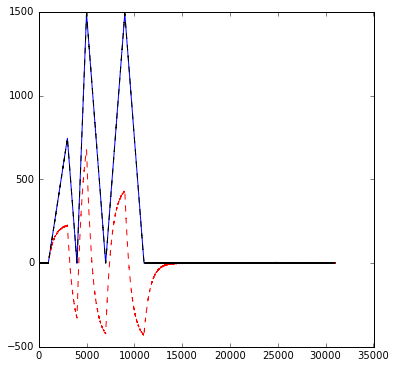

pmt = 7, coeff_blr = 0.001612068, coeff_c = 3.127641e-06
sum: signal_i = 6334738.56 
sum: signal_r =6342410.30343
signal_i/signal_r =0.998790405688


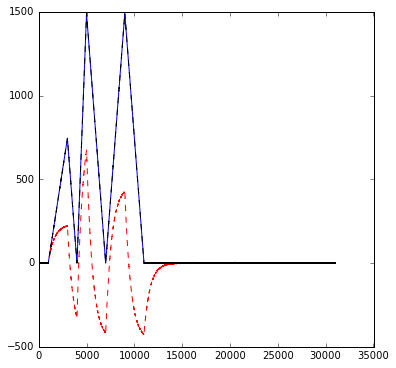

pmt = 8, coeff_blr = 0.001600683, coeff_c = 3.064543e-06
sum: signal_i = 6334738.56 
sum: signal_r =6341807.11542
signal_i/signal_r =0.998885403594


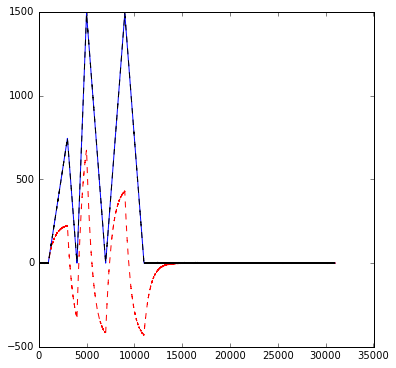

pmt = 9, coeff_blr = 0.001592718, coeff_c = 3.040463e-06
sum: signal_i = 6334738.56 
sum: signal_r =6341048.54863
signal_i/signal_r =0.999004898231


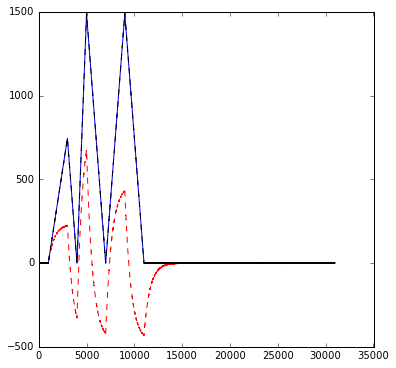

pmt = 10, coeff_blr = 0.001575192, coeff_c = 3.113604e-06
sum: signal_i = 6334738.56 
sum: signal_r =6340247.65214
signal_i/signal_r =0.999131091963


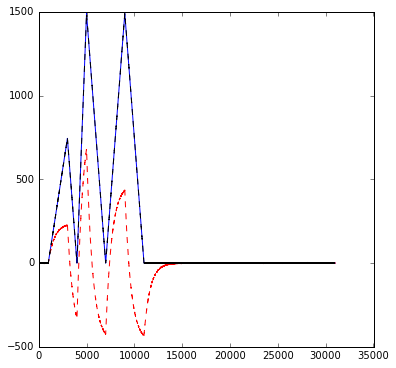

pmt = 11, coeff_blr = 0.001596322, coeff_c = 3.185979e-06
sum: signal_i = 6334738.56 
sum: signal_r =6341838.80298
signal_i/signal_r =0.998880412575


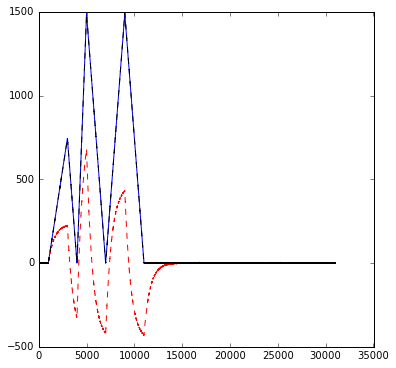

In [301]:
cwfm(cfee, signal_i)

In [302]:
def pstat(pfee, signal_i, event_list=[0]):
    """
    plots waveforms all PMTs
    """
    
    coef=pfee.freq_LHPFd*np.pi
    coef_c = pfee.coeff_c
    PMT = [-1,0,1,2,3,4,5,6,7,8,9,10,11]
    
    recons_pmt = np.zeros(len(PMT))
    RECONS = []
    t0= time.time()
    for event in event_list:
        for i in PMT:
            if i>-1: 
                coef = pfee.coeff_blr_pmt[i]
                coef_c = pfee.coeff_c_pmt[i]
        
            signal_outn = FE.signal_v_fee(pfee, signal_i, i)   # convolution and noise FEE + PMT 
            signal_outnd = FE.noise_adc(pfee, signal_outn*FE.v_to_adc())  # NOISE DAQ
            signal_out_cf = FE.signal_clean(pfee, signal_outnd, i)  # cleaning.
            signal_r, acum = cdeconv_simple(signal_out_cf,coef=coef)
            recons_pmt[i]=np.sum(signal_i[1000:11000])*FE.i_to_adc()/np.sum(signal_r[1000:11000])
        RECONS.append(recons_pmt)
    t1 = time.time()
    dt = t1 - t0
    print("pstat has run over {} events in {} seconds".format(event+1, dt))
    return np.array(RECONS)

In [303]:
R = pstat(pfee, signal_i, event_list=[0])

pstat has run over 1 events in 0.0653831958771 seconds


In [304]:
R

array([[ 0.99910152,  0.99876486,  0.99913732,  0.9990043 ,  0.99902273,
         0.99891114,  0.99913463,  0.9986302 ,  0.99899143,  0.99928175,
         0.99897525,  0.99888509,  0.9995817 ]])

(array([ 1.,  1.,  2.,  3.,  2.,  2.,  1.,  0.,  0.,  1.]),
 array([ 0.9986302 ,  0.99872535,  0.9988205 ,  0.99891565,  0.9990108 ,
         0.99910595,  0.9992011 ,  0.99929625,  0.9993914 ,  0.99948655,
         0.9995817 ]),
 <a list of 10 Patch objects>)

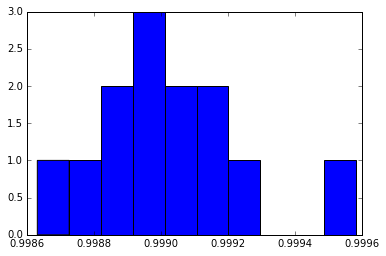

In [305]:
plt.hist(R[0])

In [316]:
R = pstat(pfee, signal_i, event_list=range(1000))

pstat has run over 1000 events in 54.8156409264 seconds


(array([ 1200.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,   100.]),
 array([ 0.9987935 ,  1.01864324,  1.03849299,  1.05834274,  1.07819248,
         1.09804223,  1.11789198,  1.13774172,  1.15759147,  1.17744122,
         1.19729096]),
 <a list of 10 Patch objects>)

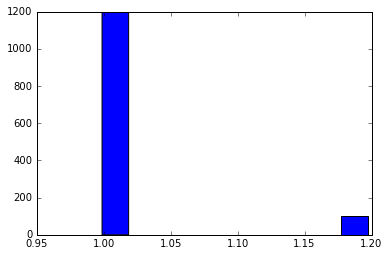

In [310]:
plt.hist(R.flatten())

In [311]:
def cstat(cfee, signal_i, event_list=[0]):
    """
    plots waveforms all PMTs
    """
    
    coef=cfee.coeff_blr
    coef_c = cfee.coeff_c
    PMT = [-1,0,1,2,3,4,5,6,7,8,9,10,11]
    
    recons_pmt = np.zeros(len(PMT))
    RECONS = []
    t0= time.time()
    for event in event_list:
        for i in PMT:
            if i>-1: 
                coef = cfee.coeff_blr_pmt[i]
                coef_c = cfee.coeff_c_pmt[i]
        
            signal_outn = cfee.signal_v_fee(signal_i, i)   # convolution and noise FEE + PMT 
            signal_outnd = cfee.noise_adc(signal_outn*feg.v_to_adc())  # NOISE DAQ
            signal_out_cf = cfee.signal_clean(signal_outnd, i)  # cleaning.
            signal_r, acum = cdeconv_simple(signal_out_cf,coef=coef)
            recons_pmt[i]=np.sum(signal_i[1000:11000])*FE.i_to_adc()/np.sum(signal_r[1000:11000])
        RECONS.append(recons_pmt)
    t1 = time.time()
    dt = t1 - t0
    print("cstat has run over {} events in {} seconds".format(event+1, dt))
    return np.array(RECONS)

In [314]:
R2 = cstat(cfee, signal_i, event_list=range(1000))

cstat has run over 1000 events in 49.2668068409 seconds


(array([ 12000.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,   1000.]),
 array([ 0.99868226,  1.01859142,  1.03850058,  1.05840974,  1.0783189 ,
         1.09822806,  1.11813723,  1.13804639,  1.15795555,  1.17786471,
         1.19777387]),
 <a list of 10 Patch objects>)

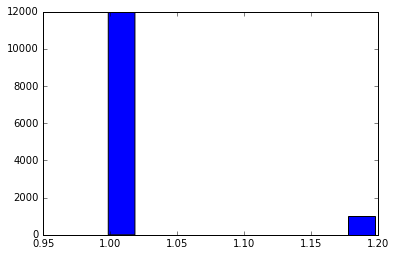

In [315]:
plt.hist(R2.flatten())

## Conclusion: Toy signals

#### Cython does no improve the performance of python substantially here. The execution speed is dominated by the SciPY functions which are already C-fast, and all the rest amounts for some 10 %. 

#### The only caveat is that the signals used in this example are small. Longer signals may result in a difference of performance, but a priori it should go in the direction of making the cython even less relevant, since the SciPy operations should be even more dominant

### Real signals

In [318]:
import tables

In [319]:
e40 =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/CalibElectrons/electrons.40.0keV.z250mm.next_1000.root.h5','r+')

In [322]:
e40

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/CalibElectrons/electrons.40.0keV.z250mm.next_1000.root.h5, title='', mode='r+', root_uep='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/pmtrd (EArray(1000, 12, 800000), zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 32768)
/sipmrd (EArray(1000, 1792, 800), zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 50, 800)
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float32Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float32Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (2340,)
/MC (Group) ''
/MC/MCTracks (Table(4862,), zl

In [323]:
pmtrd = e40.root.pmtrd

In [324]:
def simulate_pmt_response(event, pmtrd):
    """
    Input:
     1) extensible array pmtrd
     2) event_number

    returns:
    array of raw waveforms (RWF), obtained by convoluting pmtrd_ with the PMT
    front end electronics (LPF, HPF)
    array of BLR waveforms (only decimation)
    """

    spe = FE.SPE()  # spe
    # FEE, with noise PMT
    fee = FE.FEE(noise_FEEPMB_rms=FE.NOISE_I, noise_DAQ_rms=FE.NOISE_DAQ)
    NPMT = pmtrd.shape[1]
    RWF = []
    BLRX = []
    DataPMT = loadDB.DataPMT()
    adc_to_pes = np.abs(DataPMT.adc_to_pes.values)
    for pmt in range(NPMT):
        # signal_i in current units
        cc = adc_to_pes[pmt] / FE.ADC_TO_PES
        signal_i = FE.spe_pulse_from_vector(spe, pmtrd[event, pmt])
        # Decimate (DAQ decimation)
        signal_d = FE.daq_decimator(FE.f_mc, FE.f_sample, signal_i)
        # Effect of FEE and transform to adc counts
        signal_fee = FE.signal_v_fee(fee, signal_d, pmt) * FE.v_to_adc()
        # add noise daq
        signal_daq = cc * FE.noise_adc(fee, signal_fee)
        # signal blr is just pure MC decimated by adc in adc counts
        signal_blr = cc * FE.signal_v_lpf(fee, signal_d)*FE.v_to_adc()
        # raw waveform stored with negative sign and offset
        RWF.append(FE.OFFSET - signal_daq)
        # blr waveform stored with positive sign and no offset
        BLRX.append(FE.OFFSET - signal_blr)
    return np.array(RWF), np.array(BLRX)


In [325]:
RWF,BLRX = simulate_pmt_response(0, pmtrd)

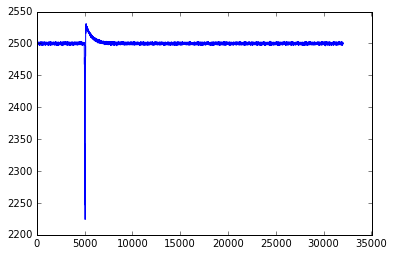

In [326]:
plt.plot(RWF[0])

In [327]:
def diomira_ploop(event_list=range(10)):
    t0= time.time()
    for event in event_list:
        RWF,BLRX = simulate_pmt_response(0, pmtrd)
    
    t1 = time.time()
    dt = t1 - t0
    print("diomira_ploop has run over {} events in {} seconds".format(event+1, dt))
        

In [344]:
diomira_ploop(event_list=range(100))

diomira_ploop has run over 100 events in 44.6333379745 seconds


In [339]:
def csimulate_pmt_response(event, pmtrd):
    """
    Input:
     1) extensible array pmtrd
     2) event_number

    returns:
    array of raw waveforms (RWF), obtained by convoluting pmtrd_ with the PMT
    front end electronics (LPF, HPF)
    array of BLR waveforms (only decimation)
    """

    spe = SPE()  # spe
    # FEE, with noise PMT
    fee = FEE(coeff_blr_pmt, coeff_c_pmt, feg.NOISE_I, feg.NOISE_DAQ) 
    NPMT = pmtrd.shape[1]
    RWF = []
    BLRX = []
    DataPMT = loadDB.DataPMT()
    adc_to_pes = np.abs(DataPMT.adc_to_pes.values)
    for pmt in range(NPMT):
        # signal_i in current units
        cc = adc_to_pes[pmt] / feg.ADC_TO_PES
        signal_i = spe.spe_pulse_from_pes(pmtrd[event, pmt])
        # Decimate (DAQ decimation)
        signal_d = fee.daq_decimator(feg.f_mc, feg.f_sample, signal_i)
        # Effect of FEE and transform to adc counts
        signal_fee = fee.signal_v_fee(signal_d, pmt) * feg.v_to_adc()
        # add noise daq
        signal_daq = cc * fee.noise_adc(signal_fee)
        # signal blr is just pure MC decimated by adc in adc counts
        signal_blr = cc * fee.signal_v_lpf(signal_d)*feg.v_to_adc()
        # raw waveform stored with negative sign and offset
        RWF.append(feg.OFFSET - signal_daq)
        # blr waveform stored with positive sign and no offset
        BLRX.append(feg.OFFSET - signal_blr)
    return np.array(RWF), np.array(BLRX)



In [340]:
RWF,BLRX = csimulate_pmt_response(0, pmtrd)

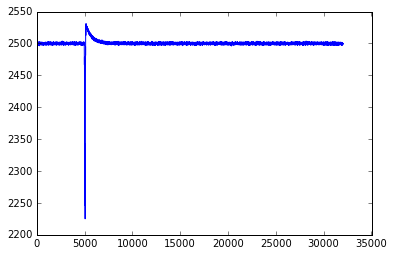

In [341]:
plt.plot(RWF[0])

In [342]:
def diomira_cloop(event_list=range(10)):
    t0= time.time()
    for event in event_list:
        RWF,BLRX = csimulate_pmt_response(0, pmtrd)
    
    t1 = time.time()
    dt = t1 - t0
    print("diomira_cloop has run over {} events in {} seconds".format(event+1, dt))
      

In [345]:
diomira_cloop(event_list=range(100))

diomira_cloop has run over 100 events in 42.5586659908 seconds


#### As expected, no gain from cython

### PMT simulation in DIOMIRA takes 45/100 seconds

In [346]:
45./100.

0.45